# Full waveform inversion

This tutorial demonstrates how to perform full waveform inversion (FWI) using the [COFII framework](https://github.com/ChevronETC) and Azure Batch. This example is based on the cluster version of the COFII FWI tutorial, which can be found [here](https://github.com/ChevronETC/Examples/blob/main/50_fwi/02_fwi_l2_dynamic.ipynb).

## Set up

We start with setting the environment variables to our credential and parameter files:

In [1]:
# Install required packages
using Pkg;
Pkg.add(["DistributedArrays", "DistributedOperations", "Schedulers", "PyPlot", "LineSearches", "Optim"])
Pkg.add(["Jets", "DistributedJets", "JetPack", "JetPackDSP", "WaveFD", "JetPackWaveFD"])

# Set paths to credentials + parameters
ENV["CREDENTIALS"] = joinpath(pwd(), "../..", "credentials.json")
ENV["PARAMETERS"] = joinpath(pwd(), "parameters_image.json")

# Load package
using AzureClusterlessHPC
batch_clear();

Next, we start the pool. As specified in the parameter file, we use a pool with 16 nodes.

In [2]:
# Create pool
# Set "_JULIA_DEPOT_PATH": "/root/.julia" in parameters.json
image_resource_id = "/subscriptions/xxxxxxxxxxxx/resourceGroups/my-resource-group-name/providers/Microsoft.Compute/galleries/my-image-gallery-name/images/my-image-name/versions/my-tag"
create_pool(image_resource_id=image_resource_id);

Created pool 1 of 1 in southcentralus with 16 nodes.


## Prepare models

We load all required packages for this example and tag the statement with the `@batchdef` macro to make all packages available on the batch worker nodes:

In [3]:
@batchdef begin
    using Distributed, DistributedOperations, Jets, JetPack, JetPackDSP, JetPackWaveFD, Random
    using LinearAlgebra, LineSearches, Logging, Optim, PyPlot, Printf, WaveFD
end;

Next, we read the true velocity model:

In [4]:
v = read!("../../data/marmousi_vp_20m_176x851.bin", Array{Float32}(undef, 176,851));

# Subsample model
v = v[1:2:end,1:2:end]
dz,dx = 40.0,40.0
nz,nx = size(v)
@show dz,dx
@show nz,nx;

(dz, dx) = (40.0, 40.0)
(nz, nx) = (88, 426)


We create two versions of the velocity model: one slightly smoothed version which will be used to generate the observed data. The second version is a strongly smoothed version and will serve as the initial model for FWI.

In [5]:
# smoothing for the true model
ns1 = 1
P1 = JopPad(JetSpace(Float32,nz,nx), -ns1:nz+ns1, -ns1:nx+ns1, extend=true)
S1 = JopConvolve(range(P1), smoother=:rect, n=(ns1,ns1))
R1 = JopPad(JetSpace(Float32,nz,nx), -ns1:nz+ns1, -ns1:nx+ns1, extend=false)
s1 = R1' ∘ S1 ∘ P1 * (1 ./ v)
v1 = 1 ./(s1);

The FWI initial model is obtained as follows:

In [6]:
# smoothing for the initial model
ns2 = 5
P2 = JopPad(JetSpace(Float32,nz,nx), -ns2:nz+ns2, -ns2:nx+ns2, extend=true)
S2 = JopConvolve(range(P2), smoother=:rect, n=(ns2,ns2))
R2 = JopPad(JetSpace(Float32,nz,nx), -ns2:nz+ns2, -ns2:nx+ns2, extend=false)
s2 = R2' ∘ S2 ∘ P2 * (1 ./ v)
v2 = 1 ./(s2);

We reset the velocity in the water layer to the true water velocity:

In [7]:
# Replace water layer
v1[v.==1500.0] .= 1500.0
v2[v.==1500.0] .= 1500.0;

## Model the data

The first step of the FWI example is to model the observed data using the slightly smoothed velocity model. We generate an acquisition setup with 16 source locations:

In [8]:
# Shot locations
nshots = 16
sx = round.(Int,collect(range(0,stop=(nx-1)*dx,length=nshots)));

To later mute the gradient in the water layer, we define the following water column mute:

In [9]:
# Water bottom mask
wb_mask = ones(Float32,size(v))
wb_mask[v.==1500.0] .= 0;

For modeling purposes, we provide a directory in which we store the temporary wavefield files:

In [10]:
# Scratch space for temp files
@batchdef scratch = pwd()
isdir(scratch);

Next, we define our forward modeling function, which will be executed as a multi-task batch job. The modeling function takes the source number, a future to the velocity model, as well as some grid information as input arguments. The function returns the modeled data as a Blob Future.

In [11]:
# Objective and gradient for single shot (to be executed as a batch job)
@batchdef function build_data(ishot, _v, sx, nz, nx, dz, dx)
    
    F = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS, 2),
        ntrec = 2501,
        dtrec = 0.004,
        dtmod = 0.002,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=4.0),
        sx = sx[ishot],
        sz = dz,
        rx = dx*[0:nx-1;],
        rz = 2*dz*ones(length(0:nx-1)),
        nbz_cache = nz,
        nbx_cache = 16,
        srcfieldfile = joinpath(scratch, "field-$ishot-$(randstring()).bin"),
        reportinterval=0)
    
    # Model data
    d =F*fetch(_v)
    
    return d
end;

Before generating the data, we first broadcast the true velocity model. This returns a BatchFuture to the velocity model stored in Blob storage, which is uploaded as a resource file to the batch job. Then, we execute our modeling function using the @batchexec macro and the pmap function:

In [12]:
# Generate data
_v1 = @bcast(v1)
bctrl = @batchexec pmap(isrc -> build_data(isrc, _v1, sx, nz, nx, dz, dx), 1:nshots);

  4.161110 seconds (4.05 M allocations: 243.051 MiB, 2.49% gc time, 40.48% compilation time)


We wait for all tasks to finish, but we do not fetch the modeled data. Instead, we only hold on to the futures, which point to the objects in blob storage that correspond to our modeled data. This avoids copying the data back to our VM.

In [13]:
# Wait for tasks to finish
wait_for_tasks_to_complete(bctrl)
d_futures = bctrl.output
delete_job(bctrl);

Uploading file v1.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_F3yNk0JW_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterlesstemp]...
Uploading file task_8.dat to container [azureclusterlesstemp]...
Uploading file task_9.dat to container [azure

## Build FWI gradient and cost function

Now that we have modeled the observed data, which is stored in blob storage, we set up the objective function for full waveform inversion. We first define the `fg_shot` function, which is the function that is executed in parallel as a multi-task batch job. Arguments for functions called via batch are always passed by copy. The function takes the current source number and futures to the data and velocity model as input arguments, as well as some grid information:

In [14]:
# Objective and gradient for single shot (to be executed as a batch job)
@batchdef function fg_shot(ishot, _d, _v_fwi, sx, dz, dx; compute_grad=true)
    
    # Load velocity model into memory
    v_fwi = fetch(_v_fwi)
    nz,nx = size(v_fwi)
    v_fwi = reshape(v_fwi, nz, nx, 1)

    F = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS, 2),
        ntrec = 2501,
        dtrec = 0.004,
        dtmod = 0.002,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=4.0),
        sx = sx[ishot],
        sz = dz,
        rx = dx*[0:nx-1;],
        rz = 2*dz*ones(length(0:nx-1)),
        nbz_cache = nz,
        nbx_cache = 16,
        srcfieldfile = joinpath(scratch, "field-$ishot-$(randstring()).bin"),
        reportinterval=0)
    
    # Residual and function value
    r = F*v_fwi .-  fetch(_d)
    ϕ = norm(r)^2

    # Compute gradient
    if compute_grad
        J = jacobian(F, v_fwi)
        g = J'*r
        s = srcillum(J)
    else
        g = nothing
        s = nothing
    end
    close(F)

    # Return by copy
    return [ϕ], g, s    
end;

Next, we define the objective function that is locally evaluated by the optimization library (in this case Optim.jl). This function takes the function value, gradient and source illumination compensation as input arguments, as well as the data, the current estimate of the model and some grid information. The function computes the current function value and gradient using the objective function defined above, overwrites the current gradient and returns the function value.

In [15]:
# Multi-shot objective (to be evaluated locally)
function fg!(f, g, s, d_obs, v_fwi, sourcex, dz, dx, wb_mask, gscale)

    # Reset g and s before every iteration
    compute_grad = ~isnothing(g)
    if compute_grad
        g[:] .= 0f0
        s[:] .= 0f0
    end
    
    # Bound constraints and bcast current model
    clamp!(v_fwi, 1377, 4689)
    _v_fwi = @bcast(v_fwi)
    ϕ = [0f0]

    # Compute objective and gradient via Azure Batch
    batch_controller = @batchexec pmap(ishot -> 
        fg_shot(ishot, d_obs[ishot], _v_fwi, sourcex, dz, dx; compute_grad=compute_grad), 1:nshots)

    # Fetch output
    if compute_grad
        fetchreduce!(batch_controller, (ϕ, g, s); op=+)
    else
        fetchreduce!(batch_controller, (ϕ, nothing, nothing); op=+)
    end
    delete_job(batch_controller)

    if ~isnothing(g)
        srms = sqrt(norm(s)^2 / length(s))
        s .+= eps(Float32) * srms
        s .= s.^(-4)
        s ./= maximum(s)
        g .*= wb_mask .* s
        gscale[] = gscale[] ≈ 0 ? 20 ./ maximum(g) : gscale[]
        g .*= gscale[]
    end
    
    if ~isnothing(f)
        return .5f0 * ϕ[]
    end
end;

## Optimization

In this section, we perform FWI using a limited memory L-BFGS algorithm with bound constraints from the Optim.jl Julia library:

In [16]:
using Optim, LineSearches, PyPlot;

We initialize the array for source illumination compensation with zeros and set the gradient scaling to zero. Additionally, we create the objective function that will be passed to the optimization library. This function takes only the function value, gradient and current model estimate as input arguments and overwrites these properties. The function only returns the current function value. Arguments are passed by reference.

In [17]:
# Objective and initializations
s = zeros(Float32, nz, nx)
gscale = [0f0]
_fg!(f, g, x) = fg!(f, g, s, d_futures, x, sx, dz, dx, wb_mask, gscale);

We also define a callback function that prints the current iteration number, function value and gradient norm:

In [18]:
# Callback
function mycallback(state::OptimizationState)
    @info "iter=$(state.iteration), cost=$(state.value), |grad|=$(state.g_norm)"
    false
end
mycallback(trace::OptimizationTrace) = mycallback(trace[end]);

Next, we define the optimization algorithm, line search and maximum number of iterations (here, 25):

In [19]:
# Call Optim.jl
niter = 25
solver = LBFGS(m = niter, 
    alphaguess = LineSearches.InitialStatic(), 
    linesearch = LineSearches.BackTracking(order=3));

Finally, we run the optimization algorithm. We measure the runtime of the algorithm and print some information:

In [20]:
topt = @elapsed begin
    result = optimize(Optim.only_fg!(_fg!), v2, solver,
        Optim.Options(
            iterations = niter,
            show_trace = false,
            store_trace = true,
            show_every = 1,
            extended_trace = true,
            allow_f_increases = false,
            callback = mycallback
        )
    )
end;

  1.800107 seconds (57.25 k allocations: 3.938 MiB, 1.88% compilation time)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...
Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_syRG4ncs_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to c

┌ Info: iter=0, cost=5.4711685e6, |grad|=20.0
└ @ Main In[18]:3


  1.450498 seconds (13.26 k allocations: 1.387 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_RFGszQpn_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=1, cost=5.1013775e6, |grad|=18.557093
└ @ Main In[18]:3


  1.453052 seconds (13.26 k allocations: 1.371 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_Idkf7s0y_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=2, cost=2.5804092e6, |grad|=19.606707
└ @ Main In[18]:3


  1.452301 seconds (13.26 k allocations: 1.355 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_jCba2g0B_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=3, cost=2.490798e6, |grad|=17.13567
└ @ Main In[18]:3


  1.448824 seconds (13.26 k allocations: 1.387 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_eNmPagwE_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=4, cost=1.5927815e6, |grad|=8.419022
└ @ Main In[18]:3


  1.449535 seconds (13.27 k allocations: 1.450 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_bcfqiA0a_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=5, cost=1.325919e6, |grad|=9.355953
└ @ Main In[18]:3


  1.403403 seconds (13.27 k allocations: 1.402 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_2tfGbhYR_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=6, cost=1.1859978e6, |grad|=10.040785
└ @ Main In[18]:3


  1.442255 seconds (13.26 k allocations: 1.387 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_QGJnEKx1_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=7, cost=786795.44, |grad|=7.204943
└ @ Main In[18]:3


  1.473537 seconds (13.26 k allocations: 1.387 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_q4Mzd9AE_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=8, cost=581062.2, |grad|=6.4197884
└ @ Main In[18]:3


  1.430029 seconds (13.27 k allocations: 1.450 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_1t0SIst8_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=9, cost=500464.44, |grad|=5.4430113
└ @ Main In[18]:3


  1.446019 seconds (13.27 k allocations: 1.434 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_5LELfvn1_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=10, cost=436183.25, |grad|=4.1463
└ @ Main In[18]:3


  1.437836 seconds (13.26 k allocations: 1.371 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_UhbYsdIb_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=11, cost=263418.8, |grad|=2.924215
└ @ Main In[18]:3


  1.440173 seconds (13.27 k allocations: 1.402 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_NySOIBTK_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=12, cost=232323.36, |grad|=2.8006039
└ @ Main In[18]:3


  1.453050 seconds (13.26 k allocations: 1.355 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_5Hk9HBE0_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=13, cost=185640.31, |grad|=2.0463672
└ @ Main In[18]:3


  1.455157 seconds (13.27 k allocations: 1.402 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_x6jN3oqL_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=14, cost=120050.18, |grad|=1.4173133
└ @ Main In[18]:3


  1.526458 seconds (13.26 k allocations: 1.324 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_j77XtRrx_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=15, cost=96074.836, |grad|=1.8980529
└ @ Main In[18]:3


  1.434453 seconds (13.26 k allocations: 1.387 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_qq3lcgFh_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=16, cost=88564.18, |grad|=1.5915679
└ @ Main In[18]:3


  1.448210 seconds (13.26 k allocations: 1.371 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_1EvWbgYO_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=17, cost=81413.586, |grad|=2.5635319
└ @ Main In[18]:3


  1.437121 seconds (13.26 k allocations: 1.371 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_DBcvSnkj_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=18, cost=70957.93, |grad|=2.0816739
└ @ Main In[18]:3


  1.438165 seconds (13.26 k allocations: 1.339 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_FqPcELVm_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=19, cost=49597.37, |grad|=1.1874752
└ @ Main In[18]:3


  1.525290 seconds (13.26 k allocations: 1.371 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_pMb9McJc_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=20, cost=40139.594, |grad|=1.0905044
└ @ Main In[18]:3


  1.482621 seconds (13.26 k allocations: 1.387 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_VWOs1AmA_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=21, cost=34363.605, |grad|=0.6353849
└ @ Main In[18]:3


  1.442411 seconds (13.26 k allocations: 1.371 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_Q8rW7y58_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=22, cost=31494.762, |grad|=0.5271897
└ @ Main In[18]:3


  1.429437 seconds (13.26 k allocations: 1.371 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_MKugnHOw_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=23, cost=28197.82, |grad|=0.5142848
└ @ Main In[18]:3


  1.554787 seconds (13.26 k allocations: 1.387 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_QrupS5Ob_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=24, cost=24221.484, |grad|=0.6211871
└ @ Main In[18]:3


  1.421843 seconds (13.26 k allocations: 1.355 MiB)
Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v_fwi.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_IKBWsfD0_1]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/azureuser/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterles

┌ Info: iter=25, cost=21146.326, |grad|=0.7793633
└ @ Main In[18]:3


## Visualize results

In the final section, we print the information from the optimization algorithm and visualize the results:

In [21]:
@sprintf("Time for optimization; %.2f minutes\n", topt / 60)
@info "result=\n$result\n"

┌ Info: result=
│  * Status: failure (reached maximum number of iterations)
│ 
│  * Candidate solution
│     Final objective value:     2.114633e+04
│ 
│  * Found with
│     Algorithm:     L-BFGS
│ 
│  * Convergence measures
│     |x - x'|               = 1.20e+02 ≰ 0.0e+00
│     |x - x'|/|x'|          = 2.57e-02 ≰ 0.0e+00
│     |f(x) - f(x')|         = 3.08e+03 ≰ 0.0e+00
│     |f(x) - f(x')|/|f(x')| = 1.45e-01 ≰ 0.0e+00
│     |g(x)|                 = 7.79e-01 ≰ 1.0e-08
│ 
│  * Work counters
│     Seconds run:   2163  (vs limit Inf)
│     Iterations:    25
│     f(x) calls:    40
│     ∇f(x) calls:   26
│ 
└ @ Main In[21]:2


We obtain the final model from Optim and plot the initial, true and obtained model, as well as the history of the function value:

In [22]:
vf = Optim.minimizer(result) # optimal solution
vmin=1377; vmax=4689
clamp!(vf,vmin,vmax)         # apply the box constraints
ϕ = Optim.f_trace(result)    # cost vs iteration
m = Optim.x_trace(result);   # model vs iteration

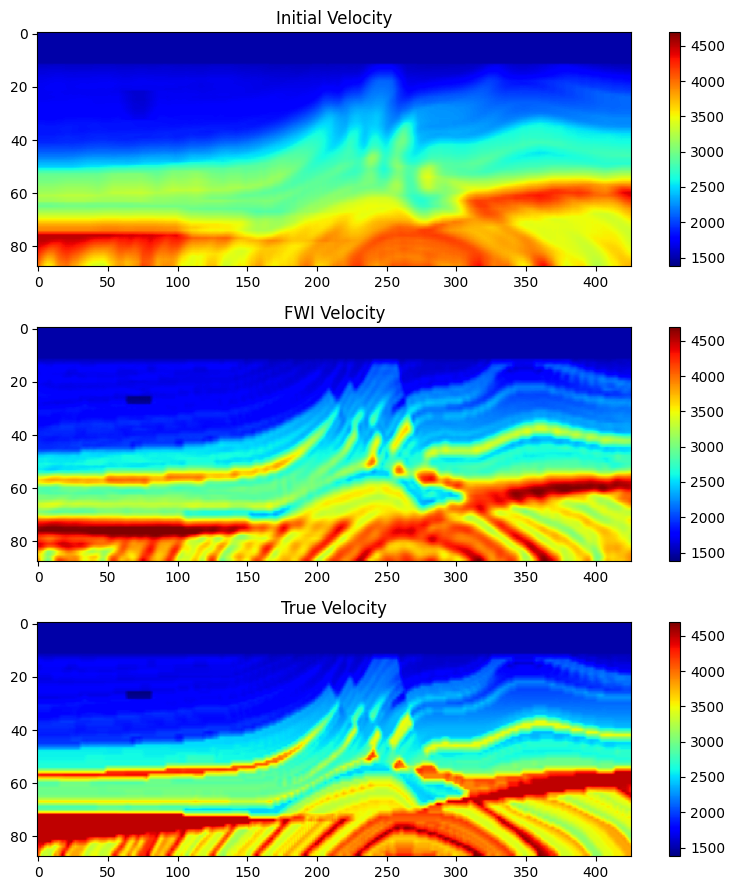

In [23]:
figure(figsize=(8,9)); clf()

subplot(3,1,1);imshow(v2,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("Initial Velocity");

subplot(3,1,2);imshow(vf,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("FWI Velocity");

subplot(3,1,3);imshow(v1,aspect="auto",cmap="jet");
colorbar(orientation="vertical");clim(vmin,vmax);title("True Velocity")

tight_layout();

The function value is plotted as follows:

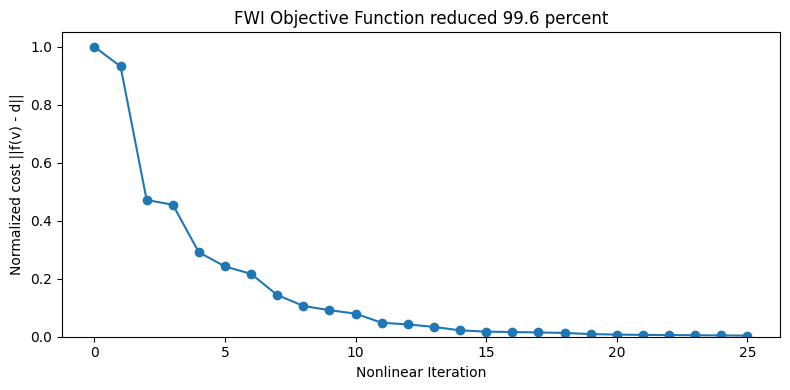

In [24]:
figure(figsize=(8,4)); clf()
iters = [0:1:length(ϕ)-1;]
plot(iters, ϕ ./ ϕ[1], marker="o")
ylim([0,1.05])
xlabel("Nonlinear Iteration")
ylabel("Normalized cost ||f(v) - d||")
title(@sprintf("FWI Objective Function reduced %.1f percent", 100 * (ϕ[1] - ϕ[end]) / ϕ[1]));
tight_layout();

The last step is the clean up of our resources. We delete the blob container that contains all temporary files and delete the batch pool:

In [25]:
# Delete container and pool specified in the parameter json file
delete_container()
delete_all_jobs()
delete_pool();

## Copyright

Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License (MIT). See LICENSE in the repo root for license information.